In [1]:
import pickle
import numpy as np

In [2]:
with open('../Chat-bot-using-Babi-Dataset/Dataset/train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('../Chat-bot-using-Babi-Dataset/Dataset/test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

train_data and test_data is a list of datapoints for training and testing the model. It is basically a list of tuples. And each of the tuples hold again a list of story question and answer.

CREATING A VOCABULARY. Here we create a vocabulary using both training and test datasets.

In [4]:
all_data = train_data + test_data

vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('no')
vocab.add('yes')

In [6]:
# We need this little place holder for later when we create pad sequences
vocab_len = len(vocab) + 1

In [8]:
# Longest story, we need this for padding our sequences
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lens)

In [9]:
# Longest question
max_question_len = max([len(data[1]) for data in all_data])

Vectorizing the data

In [13]:
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'is': 1,
 'daniel': 2,
 'garden': 3,
 'john': 4,
 'milk': 5,
 'bathroom': 6,
 'hallway': 7,
 'went': 8,
 'grabbed': 9,
 'yes': 10,
 'left': 11,
 'dropped': 12,
 'the': 13,
 'back': 14,
 'kitchen': 15,
 'picked': 16,
 'journeyed': 17,
 'up': 18,
 'sandra': 19,
 'took': 20,
 'football': 21,
 '?': 22,
 'down': 23,
 'office': 24,
 'to': 25,
 'moved': 26,
 '.': 27,
 'there': 28,
 'no': 29,
 'bedroom': 30,
 'mary': 31,
 'travelled': 32,
 'got': 33,
 'apple': 34,
 'put': 35,
 'in': 36,
 'discarded': 37}

In [19]:
def vectorize(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len =max_question_len):
    # Stories X
    X = []
    # Question Xq
    Xq = []
    # Y Correct Answer (yes/no)
    Y= []
    
    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        
        # +1 is reserved for padding
        y = np.zeros(len(word_index)+1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_question_len), np.array(Y))

In [20]:
input_train, question_train, answers_train = vectorize(train_data)
input_test, question_test, answers_test = vectorize(test_data)

In [48]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [66]:
# PLACEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [67]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# (samples, story_maxLen, embedding_dim)

In [68]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# (samples, story_maxLen, max_question_len)

In [69]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# (samples, question_maxLen, embedding_dim)

In [70]:
# ENCODED <----- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [71]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [72]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [73]:
answer = concatenate([response, question_encoded])

In [74]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_2')>

In [75]:
answer = LSTM(32)(answer)

In [76]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer) # (samples, vocab_size) # YES/NO

In [77]:
answer = Activation('softmax')(answer)

In [78]:
model = Model([input_sequence, question], answer)

In [79]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, None, 64)     2432        ['input_5[0][0]']                
                                                                                                  
 sequential_9 (Sequential)      (None, 6, 64)        2432        ['input_6[0][0]']                
                                                                                            

In [81]:
history = model.fit([input_train, question_train],answers_train, batch_size=32, epochs=150, validation_data=([input_test,question_test],answers_test))

Epoch 1/150
313/313 [==============================] - 4s 7ms/step - loss: 0.8932 - accuracy: 0.4886 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 2/150
313/313 [==============================] - 2s 6ms/step - loss: 0.7044 - accuracy: 0.5027 - val_loss: 0.6963 - val_accuracy: 0.4970
Epoch 3/150
313/313 [==============================] - 2s 6ms/step - loss: 0.6972 - accuracy: 0.5012 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 4/150
313/313 [==============================] - 2s 6ms/step - loss: 0.6960 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/150
313/313 [==============================] - 2s 7ms/step - loss: 0.6960 - accuracy: 0.4947 - val_loss: 0.6949 - val_accuracy: 0.5030
Epoch 6/150
313/313 [==============================] - 2s 6ms/step - loss: 0.6955 - accuracy: 0.4952 - val_loss: 0.7023 - val_accuracy: 0.4970
Epoch 7/150
313/313 [==============================] - 2s 7ms/step - loss: 0.6953 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4970

Epoch 58/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6669 - accuracy: 0.5799 - val_loss: 0.6526 - val_accuracy: 0.6160
Epoch 59/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6538 - accuracy: 0.6007 - val_loss: 0.6383 - val_accuracy: 0.6350
Epoch 60/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6472 - accuracy: 0.6237 - val_loss: 0.6234 - val_accuracy: 0.6730
Epoch 61/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6422 - accuracy: 0.6320 - val_loss: 0.6177 - val_accuracy: 0.6580
Epoch 62/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6405 - accuracy: 0.6460 - val_loss: 0.6113 - val_accuracy: 0.6840
Epoch 63/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6217 - accuracy: 0.6552 - val_loss: 0.5970 - val_accuracy: 0.6880
Epoch 64/150
313/313 [==============================] - 3s 8ms/step - loss: 0.6099 - accuracy: 0.6792 - val_loss: 0.5876 - val_accuracy:

Epoch 115/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3119 - accuracy: 0.8711 - val_loss: 0.3685 - val_accuracy: 0.8280
Epoch 116/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3179 - accuracy: 0.8681 - val_loss: 0.4084 - val_accuracy: 0.8260
Epoch 117/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3122 - accuracy: 0.8721 - val_loss: 0.3809 - val_accuracy: 0.8370
Epoch 118/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3135 - accuracy: 0.8678 - val_loss: 0.3616 - val_accuracy: 0.8330
Epoch 119/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3138 - accuracy: 0.8662 - val_loss: 0.3684 - val_accuracy: 0.8380
Epoch 120/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3099 - accuracy: 0.8669 - val_loss: 0.3727 - val_accuracy: 0.8380
Epoch 121/150
313/313 [==============================] - 3s 8ms/step - loss: 0.3089 - accuracy: 0.8720 - val_loss: 0.3954 - val_ac

In [82]:
#Saving the model
model.save('chat_bot_e150.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


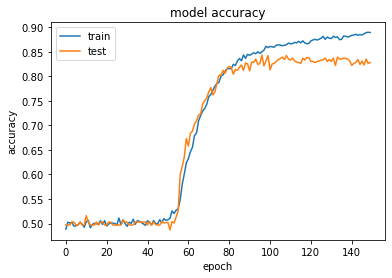

In [85]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluating on the given dataset

In [87]:
model.load_weights('chat_bot_e150.h5')
pred_results = model.predict(([input_test, question_test]))

32/32 [==============================] - 0s 2ms/step


In [88]:
#Story
print(' '.join(word for word in test_data[0][0]))

Mary got the milk there . John moved to the bedroom .


In [89]:
#Question
print(' '.join(word for word in test_data[0][1]))

Is John in the kitchen ?


In [90]:
#Answer from the dataset
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [91]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9987643


# Writing own stories and question

In [92]:
st = "John left the kitchen . Sandra dropped the football in the garden ."
qs = "Is the football in the garden ?"
mydata = [(st.split(),qs.split(),'yes')]

In [93]:
my_story,my_ques,my_ans = vectorize(mydata)

In [94]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 18ms/step


In [95]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.98056084
